# DaKanjiRecognizer - Single Kanji CNN : Training
## Setup

Import the needed libraries.

In [1]:
#std lib
import sys
import os
import time
import datetime
import tempfile
import importlib

#ML
import tensorflow as tf
import numpy as np

from PIL import Image

# data augmentation
from elasticdeform import tf as tfedf
import elasticdeform 
import RandomErasing

#plotting/showing graphics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

Because the data sets are big let's make sure that the GPU is available to speed up training.

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

GPUs Available:  /device:GPU:0


enable memory growth

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Enable mixed precision (for RTX, etc.).

In [4]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


## Setting up the Data pipeline

Read the labels for each class from file.

In [1]:
labels_1, labels_2, labels = [], [], []

# load labels from file
with open(r'Z:\data_sets\dakanji_single_kanji_cnn\encoding.txt', mode="r", encoding="utf-8") as f:
    labels_1 = list(eval(f.read()).keys())

ls = labels_1
# order the labels
indexs = sorted([str(i) for i in range(0, len(ls))])
ordered_labels = [ls[int(i)] for i in indexs]

# save the labels to text files
with open(r'E:\projects\DaKanjiRecognizerML\single_kanji_cnn\labels.txt', mode="w+", encoding="utf-8") as f:  
    f.write(''.join(ordered_labels))

Create a `tf.keras.dataset` from the saved files for test and validation.

In [12]:
#batch size
bs=1024
val_split = 0.2
h, w = 64, 64
# class names
classes = [str(i) for i in range(len(ls))]

In [6]:
#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
show_sample_font = fm.FontProperties(fname=os.path.join("..", "fonts", "NotoSerifCJKjp-Regular.otf"), size=20)

def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label, font=show_sample_font)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

## create train and validation dataset

In [13]:
t_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    #"Z:\data_sets\kanji_cnn_test",
    "Z:\data_sets\dakanji_single_kanji_cnn",
    labels="inferred",
    label_mode="categorical",
    interpolation="lanczos3",
    #class_names=classes,
    color_mode="grayscale",
    batch_size=bs,
    image_size=(h, w),
    shuffle=True,
    seed=123,
    validation_split=val_split,
    subset="training"
)

Found 13014000 files belonging to 6507 classes.
Using 10411200 files for training.


In [14]:
train_dataset = t_dataset.map(lambda x, y : (tf.cast(x, dtype=tf.float16), tf.cast(y, dtype=tf.float16)))
train_dataset = train_dataset.cache(r"Z:\data_sets\dakanji_single_kanji_cnn_cache\train")
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#print(train_dataset.take(1))

In [15]:
v_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    #"Z:\data_sets\kanji_cnn_test",
    "Z:\data_sets\dakanji_single_kanji_cnn",
    labels="inferred",
    label_mode="categorical",
    interpolation="lanczos3",
    #class_names=classes,
    color_mode="grayscale",
    batch_size=bs,
    image_size=(h, w),
    shuffle=True,
    seed=123,
    validation_split=val_split,
    subset="validation"
)

Found 13014000 files belonging to 6507 classes.
Using 2602800 files for validation.


In [16]:
val_dataset = v_dataset.map(lambda x, y : (tf.cast(x, dtype=tf.float16), tf.cast(y, dtype=tf.float16)))
val_dataset = val_dataset.cache(r"Z:\data_sets\dakanji_single_kanji_cnn_cache\test")
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#print(val_dataset.take(1))

## Defining and training the CNN
First define image image preprocessing layers.

In [17]:
@tf.function
def preprocess_tf(x):
    """
    Preprocessing for TF Lite.
    
    Args:
        x : a Tensor(batch_size, height, width, channels) of images to preprocess
        
    Return: 
        normalized and resized Tensor of images
    """
    
    batch, height, width, channels = x.shape
    
    # normalize image between [0, 1]
    m = tf.math.reduce_max(x)
    preprocessed = tf.math.divide(x, m)
    
    # resize images to (64, 64)
    preprocessed = tf.image.resize(preprocessed, (64, 64), method=tf.image.ResizeMethod.BILINEAR)

    return preprocessed


class PreprocessTFLayer(tf.keras.layers.Layer):
    def __init__(self, name="preprocess_tf", **kwargs):
        super(PreprocessTFLayer, self).__init__(name=name, **kwargs)
        self.preprocess = preprocess_tf

    def call(self, input):
        return self.preprocess(input)

    def get_config(self):
        config = super(PreprocessTFLayer, self).get_config()
        return config
    
    def get_prunable_weights(self):
        return [] 

Now define a Sequential model for image preprocessing and augmentation layers.

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomZoom, RandomRotation, RandomTranslation

img_augmentation = tf.keras.Sequential(
    [
        PreprocessTFLayer(),
        RandomErasing.RandomErasing(probability=0.3),
        
        # random data augmentation
        RandomZoom(height_factor=(-0.2, 1.0), width_factor=(-0.2, 1.0), 
            fill_mode='constant', interpolation='bilinear', fill_value=0.0
        ),
        RandomTranslation(0.2, 0.2, fill_mode="constant"),
        RandomRotation(factor=(-0.1, 0.1) , fill_mode='constant', interpolation='bilinear'),
    ],
    name = "img_augmentation"
)

In [19]:
imgs, lbs = [], []
for images, labels in train_dataset.take(1):
    for img, label in zip(images, labels):
        imgs.append(img.numpy())
        lbs.append(label.numpy())

elapsed timer: 0.8852492999999413


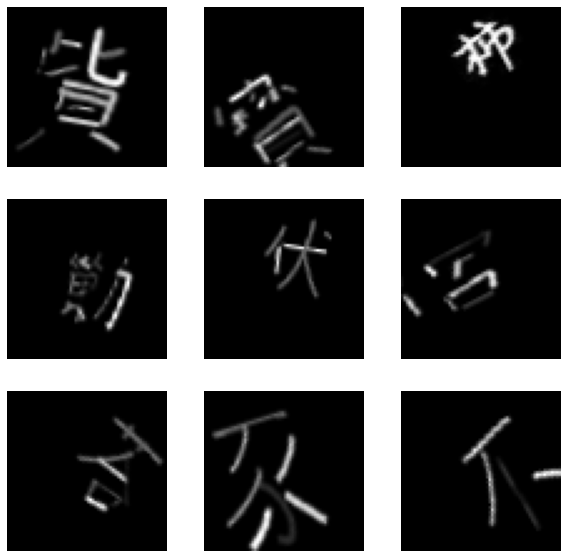

In [20]:
plt.figure(figsize=(10, 10))

t1 = time.perf_counter()
augmented_images = img_augmentation(images)
t2 = time.perf_counter()
print("elapsed timer:", t2 - t1)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().reshape((64, 64)).astype(np.float64), cmap="gray")
    plt.axis("off")


Make sure the image augmentaiton layers are working.

Create an EfficientNet Lite model and merge preprocessing, augmentation layers with it to one model.

In [21]:
from efficientnet_lite import EfficientNetLiteB0

eff_net_lite = EfficientNetLiteB0(
    include_top=True,
    weights=None,
    input_shape=(64, 64, 1),
    classes=len(ls),
    pooling="avg",
    classifier_activation="softmax",
)

f16_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, None, 1)),
    img_augmentation,
    eff_net_lite,
])
f16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_augmentation (Sequential (None, 64, 64, 1)         0         
_________________________________________________________________
efficientnetlite0 (Functiona (None, 6507)              11747915  
Total params: 11,747,915
Trainable params: 11,705,899
Non-trainable params: 42,016
_________________________________________________________________


Set a path to save model realted files and optionally load stored weights to resume training.

In [22]:
#path where the model should be saved
model_dir = os.path.join(os.getcwd(), "model")
print("model_dir:", model_dir)

#f16_model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-46-0.94.hdf5"))

model_dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model


Set the optimizer, loss function and compile the model

In [23]:
l_r = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=l_r)

METRICS = ['accuracy']

f16_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=METRICS)

Setup callbacks for the model.

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

#CHECKPOINTS
filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

# TENSORBOARD
# load the tensorboard extension
%load_ext tensorboard

# add the tensorboard callback
log_dir = os.path.join(model_dir, "tf", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list.append(tensorboard_callback)

print("tensorboard log dir:", log_dir)

# LEARNING RATE SCHEDULER
def scheduler(epoch, lr):
    return l_r - ((l_r / 100 * 4) * (epoch // 3))

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
callbacks_list.append(scheduler_callback)

tensorboard log dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\logs\20210824-204112


Finally train the model on the data set (in case of an Interrupt creates checkpoints).

In [25]:
#train the model
hist = f16_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    initial_epoch=10,
    workers=16,
    use_multiprocessing=True,
    callbacks=callbacks_list
)

## Evaluating the model

After training plot the loss and accuracy for the test and validation sets.

In [36]:
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

eff_net_lite = EfficientNetLiteB0(
    include_top=True,
    weights=None,
    input_shape=(64, 64, 1),
    classes=len(ls),
    pooling="avg",
    classifier_activation="softmax",
)

f16_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, None, 1)),
    PreprocessTFLayer(),
    eff_net_lite,
])
f16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess_tf (PreprocessTFL (None, 64, 64, 1)         0         
_________________________________________________________________
efficientnetlite0 (Functiona (None, 6507)              11747915  
Total params: 11,747,915
Trainable params: 11,705,899
Non-trainable params: 42,016
_________________________________________________________________


In [37]:
# reload values from file if necessary
f16_model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-47-0.95.hdf5"))
f16_model.compile()

In [31]:
f16_model.evaluate(val_dataset, workers=16, use_multiprocessing=True)

2542/2542 [==============================] - 149s 58ms/step - loss: 0.0000e+004s - loss: 0.0000 - ETA: 4s - loss: 0.000 - ETA - ETA: 2s - ETA: 0s - l


0.0

['セ', 'ゼ', '也', 'ヤ', 'た', '巳', 'ピ', '牾', '拒', '七']


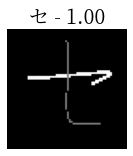

In [38]:
# load a sample
sample = tf.keras.preprocessing.image.load_img(
    path= r"Z:\data_sets\dakanji_single_kanji_cnn\100\1540.png",
    color_mode="grayscale",
    target_size=(64, 64),
)
sample = tf.keras.preprocessing.image.img_to_array(sample)
sample = sample.reshape((1, 64, 64, 1))

# run inference
prediction = f16_model.predict(sample)[0]

# output 10 most liekly predictions
ind = np.argpartition(prediction, -10)[-10:]
q = ind[np.argsort(prediction[ind])]
print([ordered_labels[i] for i in reversed(q)])

# show the most confident prediction and the image
show_image(sample.reshape((64, 64)), ordered_labels[prediction.argmax()] + " - %.2f" % prediction.max())

## Saving the model

The model is perfoming very well therefore save the trained model as a "*.pb" file.

In [33]:
f16_model.save(
    os.path.join(model_dir, "tf", "trained_model"),
)

E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\trained_model\assets


Finally convert the model to a TF-Light model to be used in applications.

In [39]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(f16_model)

# set quantization, additional ops
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model.
print(os.path.join(model_dir, "tflite", "model.tflite"))
with open(os.path.join(model_dir, "tflite", "model.tflite"), 'wb') as f:
  f.write(tflite_model)


E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:\Users\dario\AppData\Local\Temp\tmpj73i01k5\assets


INFO:tensorflow:Assets written to: C:\Users\dario\AppData\Local\Temp\tmpj73i01k5\assets


E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tflite\model.tflite


Load the tflite model and check that it is working.

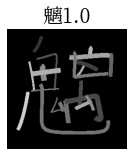

In [48]:
size = 256

# create a tf lite interpreter
interpreter = tf.lite.Interpreter(os.path.join(model_dir, "tflite", "model.tflite"))

# resize the input tensor
interpreter.resize_tensor_input(0, [1, size, size, 1])
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
sample = tf.keras.preprocessing.image.load_img(
    path= r"Z:\data_sets\dakanji_single_kanji_cnn\6340\300.png",
    color_mode="grayscale",
    target_size=(size, size)
)
sample = tf.keras.preprocessing.image.img_to_array(sample).reshape((1, size, size, 1))
interpreter.set_tensor(input_details[0]['index'], sample)

# run interpreter
interpreter.invoke()
output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

# show prediction
title = ordered_labels[output_data.argmax()] + str(output_data[0][output_data.argmax()])
show_image(sample.reshape(size, size), title)